# Batch EM (v1)

First implementation following the notation in the paper.

In [142]:
from typing import List
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl


%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s', level=logging.DEBUG)
logger = logging.getLogger(__name__)

logger.setLevel(logging.INFO)

##################
# tools.py
##################

def check_spd(x, rtol=1e-05, atol=1e-08):
    """ Based on https://stackoverflow.com/a/42913743 and https://stackoverflow.com/a/16270026."""
    all_ev_positive = np.all(np.linalg.eigvals(x) > 0)
    is_symmetric = np.allclose(x, x.T, rtol=rtol, atol=atol)
    logger.debug("Positive definit %s", all_ev_positive) 
    if not all_ev_positive:
        logger.debug("EV %s", np.linalg.eigvals(x))
    logger.debug("symmetric: %s", is_symmetric)
    return all_ev_positive and is_symmetric

def make_ellipses(gmm: 'GaussianMixtureModel', ax):
    """Shamelessly stolen from 
    https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html"""
    
    logger.info('Axis type %s', type(ax))
    
    colors = ['navy', 'turquoise', 'darkorange','firebrick',
              'yellowgreen', 'mediumorchid','slateblue',
              'darkcyan','gold','mediumpurple','navajowhite']

    for n, color in enumerate(colors):
        
        if n==gmm.n_components:
            break
        
        covariances = gmm.covs[n]
        

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means[n], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=3)
        
    # TODO consider the model to be numpy arrays instead of lists
    
    weights: List[float] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}`")
    means: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}, elements of shape {np.asarray(x).shape[1:]}`")
    covs: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}, elements of shape {np.asarray(x).shape[1:]}`")

    def __attrs_post_init__(self):
        if not self.weights:
            rand = np.random.random((self.n_components,))
            self.weights = (rand / np.sum(rand)).tolist()
        if not self.means:
            self.means = [ np.random.random_sample(( self.n_dim,)) 
                          for i in range(self.n_components)]
        if not self.covs:
            self.covs = [ make_spd_matrix(self.n_dim) 
                         for i in range(self.n_components)]
    
    # TODO Avoid working with loops. But mvn needs to be rewritten
    def expect(self, data: np.ndarray) -> List[List[float]]:
        """Returns the responsibilities."""

        
        responsibilities = []
        for t in range(data.shape[0]):
            weights = np.asarray(self.weights)
            denominator = np.sum( [self.weights[i] * mvn.pdf(data[t], 
                                                          self.means[i], 
                                                          self.covs[i]) 
                                   for i in range(self.n_components)] )
            
            
            nominators = [self.weights[i] / denominator * mvn.pdf(data[t], 
                                                               self.means[i], 
                                                               self.covs[i]) 
                          for i in range(self.n_components)]

            responsibilities.append(nominators)
        
        return responsibilities 
    
    def maximize(self, data: np.ndarray):
        
        n_samples = data.shape[0]
        
        responsibilities = np.asarray(self.expect(data)) 
        
        assert responsibilities.shape == (n_samples, self.n_components)
        
        # responsibilities: n_samples x n_components
        
        weights = np.sum(responsibilities / n_samples, axis=0)
        self.weights = weights.tolist()
        
        assert len(self.weights) == self.n_components
        
        # responsibilities: n_samples x n_components
        # means : n_components x n_dim 
        # data: n_samples x n_dim
        # weights: n_components
        
        logger.debug("Resp. %s", responsibilities.shape)
        logger.debug("Data. %s", data.shape)
        
        means = (
            np.sum( data[:,np.newaxis,:] * responsibilities[:,:,np.newaxis], axis=0) 
            / (weights[:,np.newaxis] * n_samples)
        )
        
        assert means.shape == (self.n_components, self.n_dim)
        
        self.means = [i for i in means]
        
 
        #####################
        # Move to unit tests:
        assert np.einsum('Ti,Tj->Tij', data, data).shape == (
            data.shape[0], data.shape[1], data.shape[1]
        ) # python tuple comparison
        
        for i,d in enumerate(data):
            np.allclose(np.einsum('Ti,Tj->Tij', data, data)[i,:,:], 
                        data[i].reshape(1,-1)@data[i].reshape(-1,1))
        #####################

        # Explanation
        # einsum('Xi,Xj->Xij',a,a): outerproduct of each row with itself. For MxN array, leads to MxNxN.
        # np.newaxis increased the dimensionality of the tensor. numpy broadcasting inserts copies along 
        # such the new axes to match the other operands dimensionality. 
        # Such block operations are very efficient (and easy to read once one is used to it!)

        covs = (
            np.sum(
                np.einsum('Ti,Tj->Tij', data, data)[:,np.newaxis,:,:] * 
                responsibilities[:,:,np.newaxis,np.newaxis] /
                (weights[:,np.newaxis,np.newaxis] * n_samples), # n_samples x n_components x n_dim x n_dim
                axis=0
            ) -
            np.einsum('ki,kj->kij', means, means) # n_components x n_dim x n_dim
        )
        
        assert covs.shape == (self.n_components, self.n_dim, self.n_dim)
        
        self.covs = [i for i in covs]
        for i in self.covs:
            logger.debug("Cov: \n%s\nSPD: %s\n", i, check_spd(i) )
        
        
    def fit(self, data: np.ndarray, steps=100):
        if not data.shape[1] == self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")
        for i in range(steps):
            logger.debug("Iteration %d", i+1)
            self.maximize(data)
            
    def fit_recurse(self, data: np.ndarray, steps=100):
        pass
                
            
            

[switch_backend:225] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [54]:
import copy
gmm = GaussianMixtureModel(5)
gmm2 = copy.deepcopy(gmm)
gmm2.weights[0] is gmm.weights[0]
display(gmm)


GaussianMixtureModel(n_components=5, n_dim=3, weights=`list of length 5`, means=`list of length 5, elements of shape (3,)`, covs=`list of length 5, elements of shape (3, 3)`)

## Test data

{0: 23, 1: 20, 2: 20, 3: 17, 4: 20}


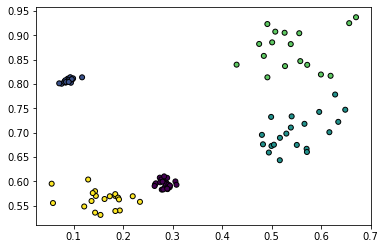

In [140]:
from kuberspatiotemporal.tools import make_gmm

n_clusters=5
X,y = make_gmm(100, n_clusters=n_clusters)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

[make_ellipses:38] Axis type <class 'matplotlib.axes._subplots.AxesSubplot'>


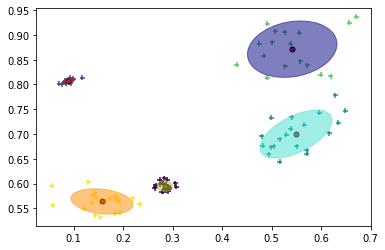

In [145]:

gmm = GaussianMixtureModel(n_clusters, n_dim=2)
display()
gmm.fit(X)


ax = plt.subplot(111)
make_ellipses(gmm, ax)

plt.scatter(X[:, 0], X[:, 1], marker='+', c=y,
            s=25, edgecolor='k')
means = np.asarray(gmm.means)
plt.scatter(means[:, 0], means[:, 1], marker='o', c='r',
            s=25, edgecolor='k')

In [21]:
X.shape

(100, 2)

## Optimatization: Computing the outer products

This section explains the optimization step in above's code

In [41]:
means = np.asarray(gmm.means)
a=np.asarray([means[i].reshape(-1,1) @ means[i].reshape(1,-1) for i in range(5) ])
%timeit np.asarray([means[i].reshape(-1,1) @ means[i].reshape(1,-1) for i in range(5) ])

16.3 µs ± 730 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
b = np.einsum('Ti,Tj->Tij', means, means)
%timeit np.einsum('ki,kj->kij', means, means)


2.92 µs ± 66.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [47]:
np.all(a==b)

True

## TODOS

* [Implement a score samples function and implement this plot](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html)